This notebook goes through how to create a **point cloud** from a **greyscale image**.

# IMPORTS

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.cores.post_processing import hard_binarization
from spomso.cores.geom_2d import PointCloud2D
from spomso.cores.geom import Points

# PARAMETERS

In [2]:
# size of the volume
co_size = 4, 4
# resolution of the volume
co_resolution = 400, 400

show = "FIELD" # BINARY, FIELD
show_midplane = True

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Import an **image** from a directory and convert it to **greyscale image**:

In [4]:
image_file_name = "lines_test_handdrawn.png"
spomso_dir = Path(os.getcwd()).resolve().parents[3]
image_path = os.path.join(spomso_dir, "Files", "test_images", image_file_name)

In [5]:
image = Image.open(image_path).convert("L")

Display the **greyscale image**:

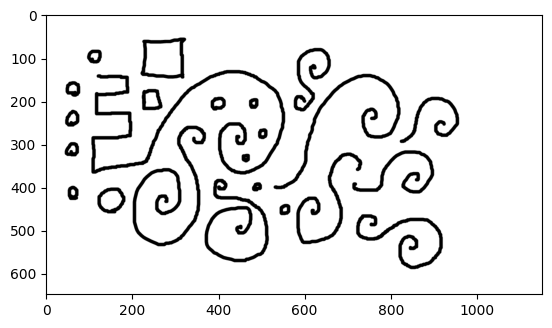

In [6]:
plt.imshow(image, cmap="binary_r")
plt.show()

Create a **point cloud** object:

In [7]:
points = Points([])

Extract the **point cloud** from the greyscale **image** [first parameter]:

In [8]:
points.from_image(image, (3, 1.5), binary_threshold=0.5)
cloud = points.cloud


All the pixels in the image with a brightness value below the **binary threshold** [third parameter] are included in the **point cloud** and the positions of the points are calculated from the specified **image size** [second parameter].

create an **SDF** from the **point cloud**:

In [9]:
final = PointCloud2D(cloud)

Give the lines a thickness of **0.01**:

In [10]:
final.onion(0.01)

<function spomso.cores.modifications.ModifyObject.onion.<locals>.new_geo_object(co, *params)>

## EVALUATE

Evaluate the SDF of the **geometry** to create a signed distance field 2D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [11]:
final_pattern = final.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [12]:
if show_midplane:
    field = smarter_reshape(final_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

if show=="BINARY":
    pattern = hard_binarization(final_pattern, 0)

# PLOT

Drawing results...
(401, 401)


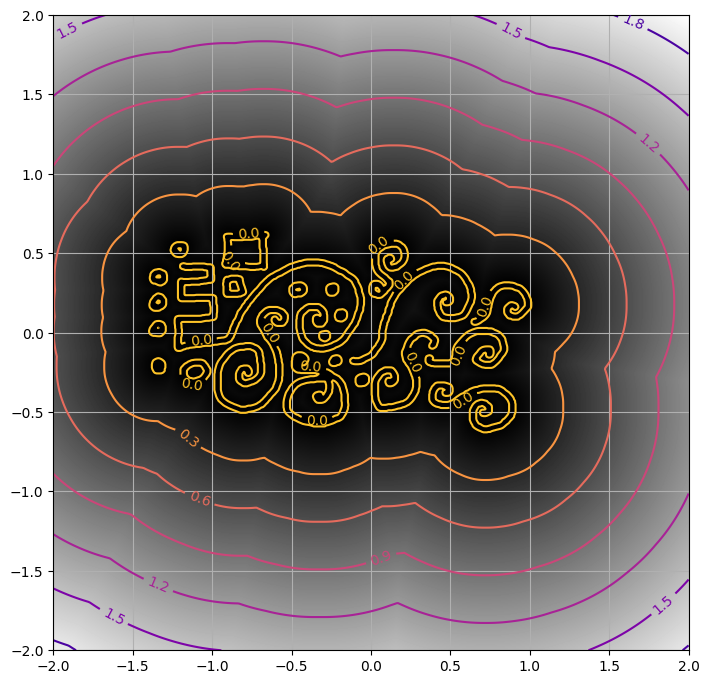

In [13]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[1]/2, co_size[1]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    print(field.shape)
    ax.imshow(field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()